# Context


Small scale patterns show moving clusters of pixels. They merge and split and change in shape. This represents a challange for motion detection with dense optimal flow estimation. Here an approach for cluster tracking is developed that allows to (1) retrive dense optical flow and (2) translate the motion patterns into a directed graph that reflects the trajectories in time.

## Cluster tracking can be understood as an optimization problem

In general one can understand cluster tracking as an optimization problem. One aims at finding an optimal attribution of clustert centers in frame at t+1 and frame t. By defining an objective function one can determine an optimal match. 

One may assume that neural signals travel at rather uniform speed and that projections exist preferably over short distances. This explains why clusters move preferably over short distances. Hence one can spatial stationarity as a term for minimization.

One may assume in additon that clusters grow rather slowly. When they split the amount of energy of the target clusters can be assumed to be similar to the energy of source clusters. This means that also the sum of target clusters can be assumed to be similar to the sum of the pixels of the source cluster (the reverse holds for splitting). Hence one can assume a energy conversation term and aim at minimizing the error between weight of source cluster(s) and weight of target cluster(s).

(Possibly one may assume additionally that the shape of the (combined) cluster at t+1 is similar to the cluster at t. In analogy one may assume that the shape of the clusters at t are similar to the combined cluster at t+1)

## Solving this optimization problem is a challange

One option to solve named optimization problem are gradient based optimization algorithms. However they require a convex error surface. The problem would have to be defined in such a way that the error surface is convex.

Because of the combinatorial explosion a brute force approach is unfeasible for a large number of clusters: Once could not find the optimal attribution of source and target clusters by trying all options.

By limiting the number of potential successor clusters at t+1 and searching only in a local neighborhood around the cluster center at t=n the computational complexity can be reduced appropriately.

## Towards finding an optimal mapping

An intermediate heuristic for cluster tracking is to simply assume that the closest clustercenter at t+1 relates to the cluster center at t. Using a "first come first serve strategy" one ends up with a a mapping where each cluster has one successor or no successor at all. This means that merges and splits are not recognized. In addition there is an potential error because of a mapping between source clusters and target clusters that are closer but are not optimal with respect to the energy conservation criterion described above.


The approach indicates however whether solving the optimization problem that is described above is an programmatically achievable task for me. The code can serve as the basis for the implementation according to the above mentioned strategy.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Import our custom utility methods

In [26]:
import sys
%reload_ext autoreload
%autoreload 2
sys.path.append('..')

from utils.visualization_tools import *
import utils.visualization_tools
from utils.data_transformations import *
import utils.data_transformations
from utils.diverse import *
import utils.diverse
from utils.cluster_tracking import FastDensityClustering

# Load preprocessed data for region of interest

In [3]:
roi = np.load("roi.npy")
roi[roi<.75] = .75
roi[roi>1] = .9
roi = normalize(roi)

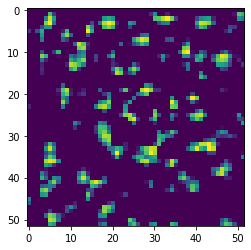

In [4]:
plt.imshow(roi[0], vmin =0, vmax=1)

In [5]:
res = FastDensityClustering.density_clustering(roi[8],  gravity_size=2, gravity_type="disk")
res1 = FastDensityClustering.density_clustering(roi[9],  gravity_size=2, gravity_type="disk")

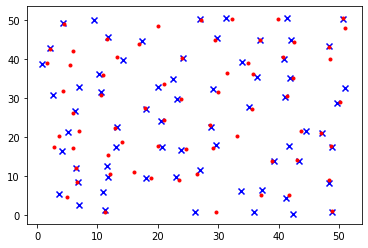

In [6]:
fig, ax = plt.subplots(1)
ax.scatter(res[0],res[1],c="b", marker="x")
ax.scatter(res1[0],res1[1],c="r",marker=".")

# Cluster tracking

In [270]:
labeled_tensor = FastDensityClustering.cluster_tracking(roi, mode="closest_center")

...................................................................................................

In [19]:
examples = labeled_tensor

In [20]:
examples[examples>100] = -1

In [21]:
%%capture
import matplotlib
import matplotlib.animation
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.prism(vals))

fig, ax = plt.subplots(1, figsize=(10,10))
im = ax.imshow(labeled_tensor[9], cmap = "prism")
ani = matplotlib.animation.FuncAnimation(fig, lambda i: [im.set_array(examples[i])], frames=len(examples)).to_jshtml()

In [22]:
HTML(ani)

In [190]:
%%capture
from matplotlib import cm

vals = np.linspace(0,1,512)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
cmap.colors[0] = [0,0,0,0]
fig, ax = plt.subplots(1,2, figsize=(10,10))
im = ax[0].imshow(labeled_tensor[1], cmap = cmap, vmin=0,vmax=int(np.max(labeled_tensor)))
im1 = ax[1].imshow(roi[1],vmin=0,vmax=1)
ani = matplotlib.animation.FuncAnimation(fig, lambda i: [im.set_array(labeled_tensor[i]),im1.set_array(roi[i])], 
                                         frames=len(labeled_tensor)-1).to_jshtml()

In [191]:
HTML(ani)

In [161]:
open("anim_side_by_side.js","w").write(ani)

1972658

We do use unique descend here as the traces tend to be very short then.

In [80]:
mapp, preliminary_label_tensor, coords = FastDensityClustering.mappings(roi,mode="closest_center")

...................................................................................................

In [575]:
import copy

00000020202020202020404040404040406060606060

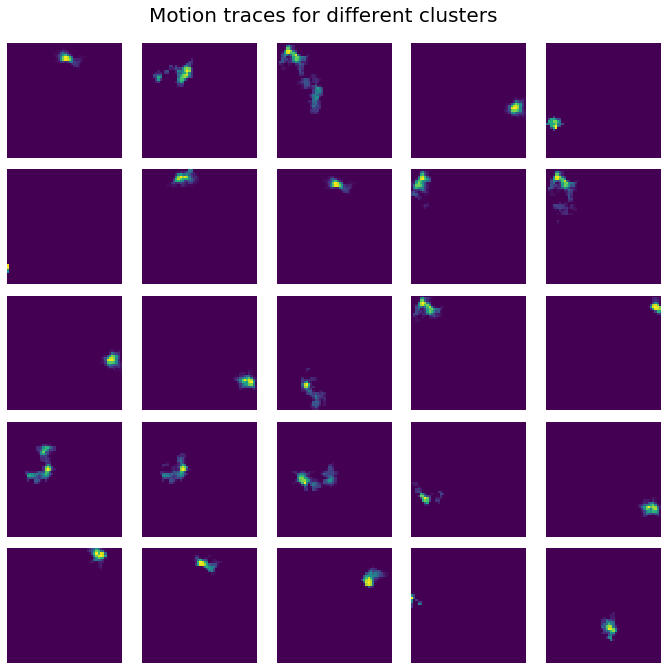

In [113]:
fig,ax = plt.subplots(5,5, figsize=(10,10))
fig.suptitle("Motion traces for different clusters", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(wspace=.1, hspace=.1)


first_cluster_center = 10#First cluster center to be plotted in layer
i = 0+first_cluster_center# The current cluster center
imgs = []
level = 0#Start slice in tensor at which tracking begins
for y in range(5):
    for x in range(5):
        kk = list(mapp[level].keys())

        if i >= len(kk):#There are no more cluster centers in layer: Preceed with different layer
            level += 20
            i = 0
        print(level, end = "")
        out = np.ndarray(preliminary_label_tensor.shape)
        out.fill(-1)
        ax[y,x].axis("off")
        tensor = FastDensityClustering.track(copy.deepcopy(mapp), kk[i], preliminary_label_tensor, level, out, 42)
        mean = FastDensityClustering.show_trace(tensor,ax[y,x])
        imgs.append(mean)
        i += 11# Increase i to plot next cluster of current layer (use increment >i such that next cluster does map to different next position for sure)

In [602]:
label_selected = roi[:99,:,:].copy()
label_selected[labeled_tensor!=3] = 0
label_selected = label_selected[15:40,:20,:30]

In [687]:
%%capture
import matplotlib
import matplotlib.animation
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

fig, ax = plt.subplots(1, figsize=(10,10))
im = ax.imshow(label_selected[18],vmin=0,vmax=1)#,interpolation="bicubic")
ani = matplotlib.animation.FuncAnimation(fig, lambda i: [im.set_array(label_selected[i])], frames=len(label_selected)-1).to_jshtml()

In [688]:
HTML(ani)

/home/elerator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


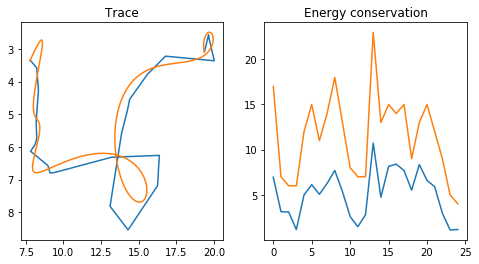

In [686]:
trace = np.array([FastDensityClustering.center_of_mass(label_selected[i]) for i in range(len(label_selected))]).T
smooth_trace = poly_smooth_2d(trace)

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].set_title("Trace")
ax[0].invert_yaxis()
ax[0].plot(*trace)
ax[0].plot(*smooth_trace)
ax[1].set_title("Energy conservation")
ax[1].plot(np.sum(label_selected,axis=(1,2)))
ax[1].plot(np.sum(label_selected>0,axis=(1,2)))

# Load test data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def normalize(tensor):
    tensor -= np.min(tensor)
    tensor /= np.max(tensor)
    return tensor
roi = np.load("roi.npy")
roi[roi<.75] = .75
roi[roi>1] = .9
roi = normalize(roi)

# Test for collapse

In [813]:
arr = np.zeros([50,100])

In [ ]:
size = 10
arr[23:23+size,20:20+size] = 42

In [ ]:
cluster_array, source_locations = FastDensityClustering.collapse(arr)

In [ ]:
assert np.sum(cluster_array>0) == 1

In [ ]:
assert np.sum(cluster_array) == size*size*42

In [ ]:
y, x = np.array(source_locations[25,22]).mean(axis=0)

# Test for density_clustering

In [ ]:
y, x, cluster_densities, labels = FastDensityClustering.density_clustering(arr)

In [ ]:
assert np.sum(labels>=0) == 100
assert np.max(labels) == 0
assert np.min(labels) == -1

In [ ]:
y

In [ ]:
x

# Test coords_to_label_matrix

In [ ]:
coords_test = np.array([[10,10],[2,5]])
mat = FastDensityClustering.coords_to_label_matrix([100,100],coords_test)
assert mat[10,2] == 0
assert mat[10,5] == 1
assert mat[20,20] == -1

In [ ]:
plt.imshow(mat)

# Test for closest label

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
testarray = np.ndarray((21,21))
testarray.fill(-1)
testarray[10,11] = 1 
plt.imshow(testarray)
FastDensityClustering.closest_label(testarray)

# Test for assign closest

In [865]:
frame = 0
gravity_size= 5
gravity_type = "uniform"

#Perform clustering
res = FastDensityClustering.density_clustering(roi[frame], gravity_size=gravity_size, gravity_type=gravity_type)
res1 = FastDensityClustering.density_clustering(roi[frame+1], gravity_size=gravity_size, gravity_type=gravity_type)

In [866]:
#Prepare data
coords_t0 = np.array([res[0],res[1]], dtype=np.int32)
coords_t1 = np.array([res1[0],res1[1]], dtype = np.int32)
label_matrix_t1 = FastDensityClustering.coords_to_label_matrix(roi[frame].shape, coords_t1)

#Assign closest
mapping, _ = FastDensityClustering.assign_closest(coords_t0, label_matrix_t1, search_window_size=5)

In [867]:
coords_t0 = [[10,20,30],[20,20,10]]

In [868]:
label_matrix_t1 = np.ndarray((50,50))
label_matrix_t1.fill(-1)
label_matrix_t1[list(np.array(coords_t0)+2)] = [0,1,2]

/home/elerator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


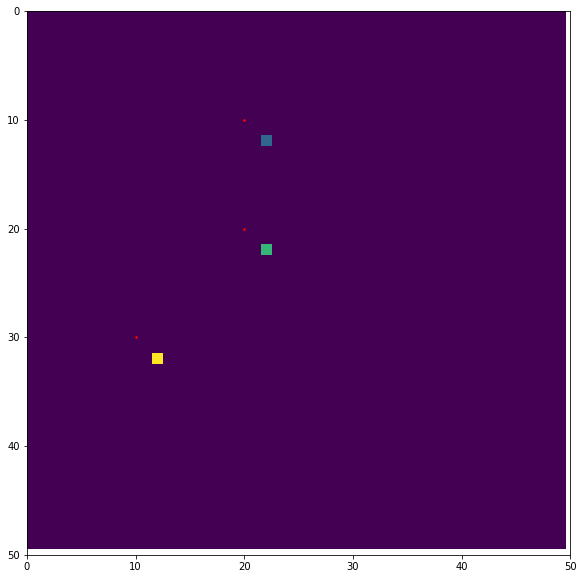

In [869]:
print_points_and_background(label_matrix_t1,coords_t0[1],coords_t0[0])

In [870]:
mapping, _ = FastDensityClustering.assign_closest(np.array(coords_t0), label_matrix_t1, search_window_size=5)

In [871]:
assert mapping[0] == 0
assert mapping[1] == 1
assert mapping[2] == 2

# Test for mappings

In [711]:
#mapp, preliminary_label_tensor, coords = FastDensityClustering.mappings(test_roi)#TODO fix that

....

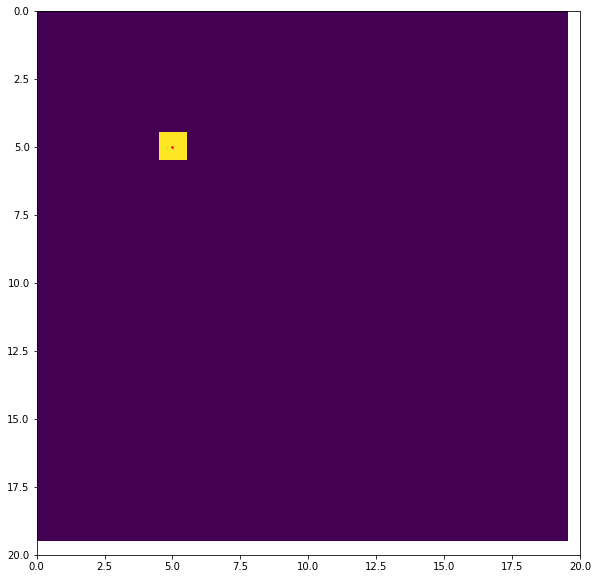

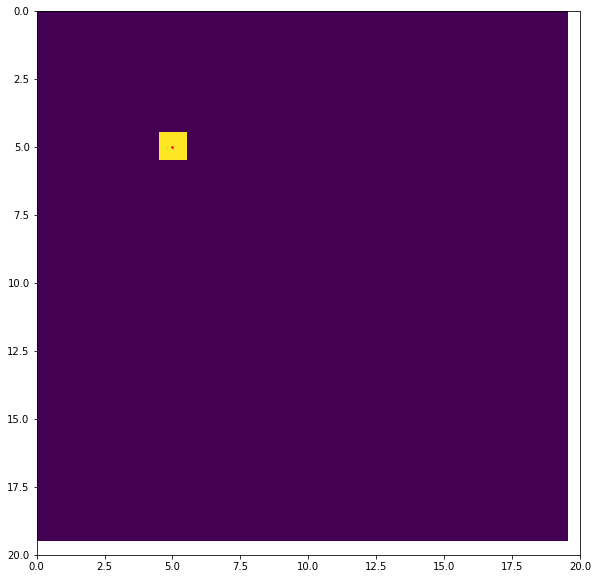

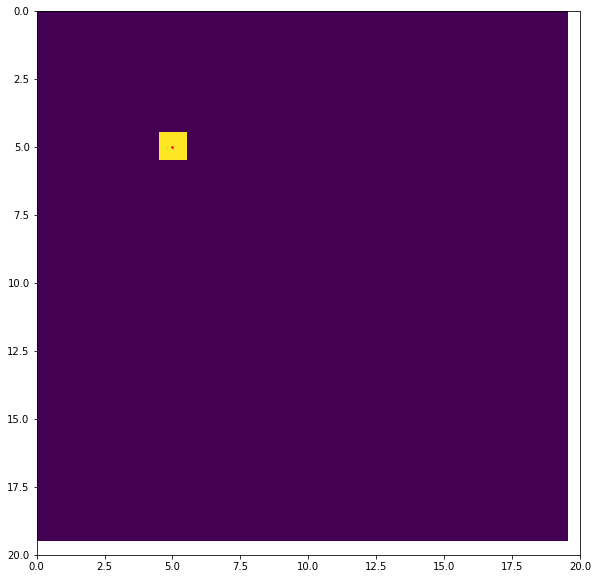

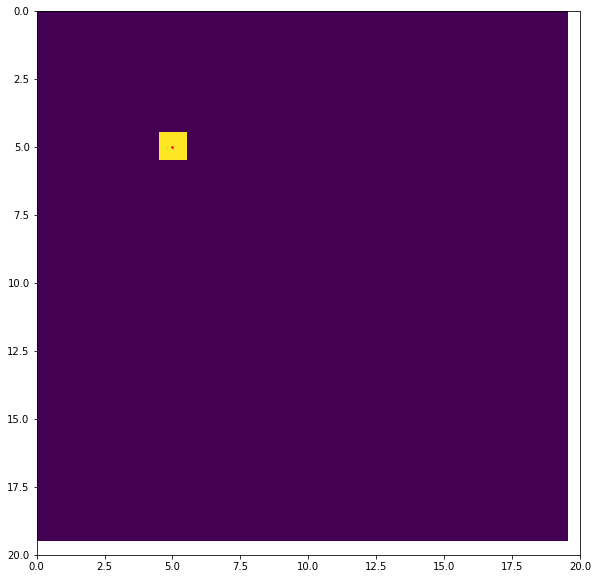

In [41]:
test_roi = np.zeros([5,20,20])
test_roi[:,5,5] = 1
mapp, preliminary_label_tensor, coords = FastDensityClustering.mappings(test_roi)
assert mapp[0][0] == 0

....

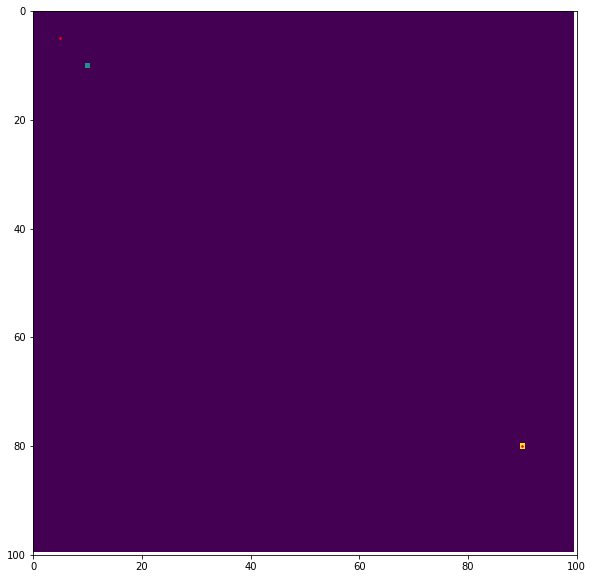

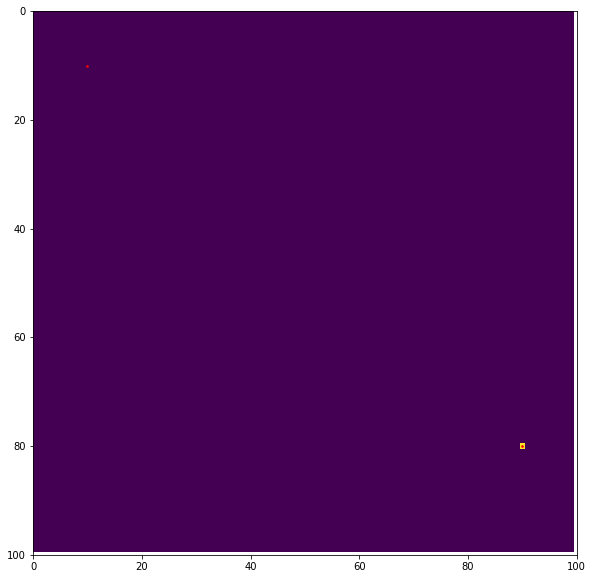

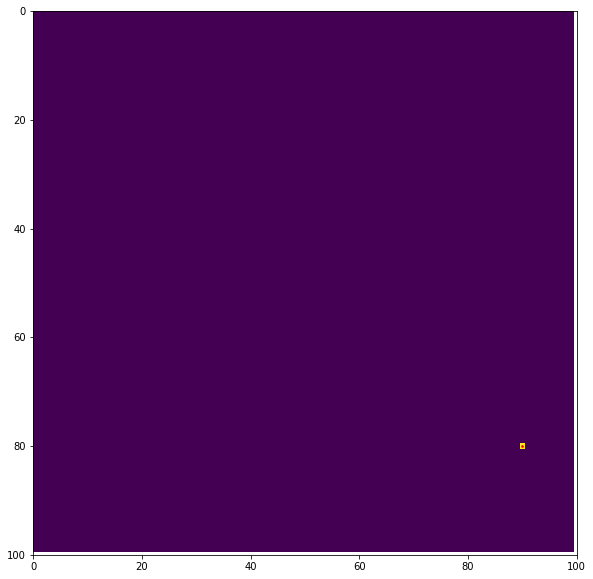

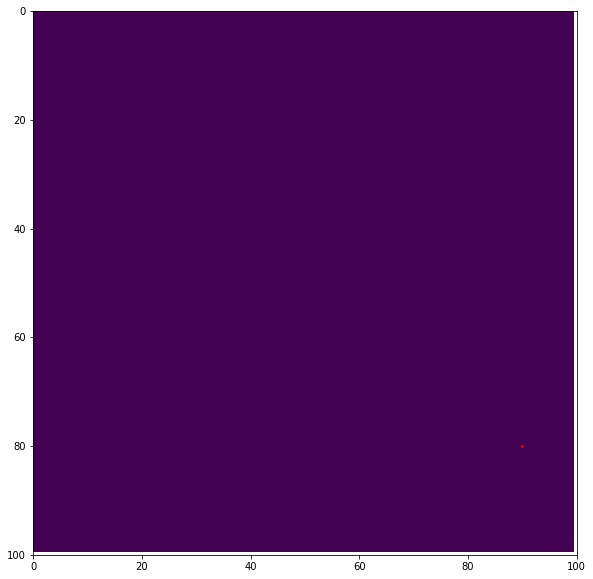

In [43]:
test_roi = np.zeros([5,100,100])
test_roi[0,5,5] = 1
test_roi[1,10,10] = 1

test_roi[0,80,90] = 1#Second cluster
test_roi[1,80,90] = 1
test_roi[2,80,90] = 1
test_roi[3,80,90] = 1

mapp, preliminary_label_tensor, coords = FastDensityClustering.mappings(test_roi)
assert mapp[0][0] == 0

In [133]:
plt.imshow(preliminary_label_tensor[2])

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
mapp, preliminary_label_tensor, coords = FastDensityClustering.mappings(roi[:3,:20,:20], frames=3)

In [83]:
mapp

array([{0: 0, 1: 1, 2: 2, 3: 4, 4: 3, 5: 6, 6: 7, 7: 3, 8: 8, 9: 9, 10: 9, 11: 7, 12: 11, 13: 12, 14: 13},
       {0: 0, 1: 1, 2: 3, 3: 5, 4: 4, 5: 4, 6: 3, 7: 6, 8: 8, 9: 7, 10: 9, 11: 10, 12: 9, 13: 9}],
      dtype=object)

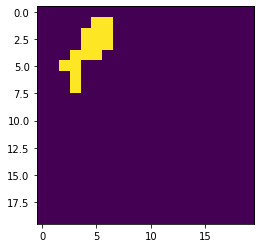

In [80]:
plt.imshow(preliminary_label_tensor[0]==0)

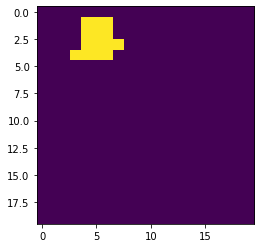

In [84]:
plt.imshow(preliminary_label_tensor[1]==0)

In [824]:
mapp

array([{0: 1, 1: 3, 2: 42, 3: 42, 4: 42, 5: 42},
       {0: 42, 1: 42, 2: 4, 3: 5, 4: 42, 5: 42}], dtype=object)

In [ ]:
%%capture
import matplotlib
import matplotlib.animation
from IPython.display import HTML
fig, ax = plt.subplots(1)
ax.scatter(*coords[0], marker=".", color ="b")

start = 0
frames = 80

def animate(i):
    global fig, ax
    ax.cla()
    print(".", end ="")
    for j in range(i,i+5):
        ax.scatter(*coords[j], marker=".")

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames)

In [ ]:
HTML(ani.to_jshtml())

In [ ]:
fig, ax = plt.subplots(1,2)
label_no = 10
ax[0].imshow(preliminary_label_tensor[0]== label_no)
ax[1].imshow(preliminary_label_tensor[1]== mapp[0][label_no])

# Tests for rek_track

In [ ]:
labels = FastDensityClustering.heuristic_tracking(mapp,preliminary_label_tensor)

In [ ]:
plt.imshow(labels[0])

In [ ]:
%%capture
from matplotlib import cm

vals = np.linspace(0,1,512)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))
fig, ax = plt.subplots(1,2, figsize=(10,10))
im = ax[0].imshow(labels[1], cmap = cmap, vmin=0,vmax=1)
im1 = ax[1].imshow(roi[1],vmin=0,vmax=1)
ani = matplotlib.animation.FuncAnimation(fig, lambda i: [im.set_array(labels[i]),im1.set_array(roi[i])], 
                                         frames=len(labels)-1)

In [ ]:
HTML(ani.to_jshtml())

In [ ]:
plt.imshow(res[3])

In [ ]:
for i, x in enumerate(coords_t1):
    mat_t1[x[0],x[1]] = i+1
#Retrieve mappings
mapping, _ = FastDensityClustering.assign_closest(coords_t0, mat_t1, search_window_size=search_window_size)

In [ ]:
#roi = roi [:,:40,:40]

In [ ]:
plt.imshow(roi[0], vmin =0, vmax=1)

In [ ]:
res = FastDensityClustering.density_clustering(roi[8],  gravity_size=2, gravity_type="disk")
res1 = FastDensityClustering.density_clustering(roi[9],  gravity_size=2, gravity_type="disk")

In [ ]:
assert np.all(np.array(res[3]>0,np.int32)-np.array(roi[8],dtype=np.int32)) == 0

In [ ]:
plt.imshow(res[3]<0)

In [ ]:
np.max(res[2])

In [ ]:
fig, ax = plt.subplots(1)
ax.scatter(res[0],res[1],c="b", marker="x")
ax.scatter(res1[0],res1[1],c="r",marker=".")

In [ ]:
import matplotlib
import matplotlib.animation
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

mapp, labels_raw, coords = FastDensityClustering.mappings(roi, search_window_size=10, frames=10)

In [ ]:
labels = FastDensityClustering.heuristic_tracking(mapp, np.array(labels_raw,dtype=np.int32))

In [ ]:
plt.imshow(np.array(labels[3]>0,dtype=np.int32)-np.array(labels_raw[3]>0,dtype=np.int32))

In [ ]:
labels[labels==0] = np.nan

In [ ]:
open("tracking.html","w").write(ani)

In [ ]:
HTML(ani)

In [ ]:
if combined_shape_similar() -> increase claim

In [ ]:
def closest_label(arr):
    coords = np.where(arr>0)
    if len(coords[0]) == 0:
        return None, [0,0]
    coords = np.array(coords)
    coords1 = coords-len(arr)//2
    idx = np.argmin(np.square(coords1[0])+np.square(coords1[1]))
    pos = coords[:,idx]
    
    return arr[pos[0],pos[1]], pos

In [ ]:
# Test
closest_label(np.array([[0,0,0],
                        [0,0,0],
                        [0,42,10]]))

In [ ]:
def assign_closest(coords_t0, mat_t1, search_window_size = 5):
    """ Computes mapping between labels based on coordinates (coords_t0) and closest pixels (mat_t1)"""
    search_window_size = (search_window_size//2)*2
    indent = search_window_size//2
    mat_t1 = np.pad(mat_t1,indent, "constant")
    mapping = {}
    mapping_operation = {}
    
    i = 0
    for y, x in coords_t0:
        snippet = mat_t1[indent+y : indent+y+search_window_size+1, indent+x : indent+x+search_window_size+1]
        label, pos = closest_label(snippet)  
        if type(label) == type(None):
            i += 1
            continue
        #TODO: check for merge

        pos[0] += y
        pos[1] += x

        mapping[i+1] = label
        mapping_operation[i] = "moved"
        mat_t1[pos[0],pos[1]] = 0
        i += 1
        
    return mapping, mapping_operation

In [ ]:
#Test
coords_t0 = np.array([[5,8],[5,8]]).T
mat_t1 = np.zeros((10,10))
mat_t1[7,7] = 41
mat_t1[5,3] = 40
mat_t2 = np.zeros((10,10))
mat_t2[7,7] = 41
mat_t2[5,3] = 40
#print_points_and_background(mat_t1, coords_t0[0],coords_t0[1])
test_res = assign_closest(coords_t0, mat_t1, search_window_size = 5)
assert test_res[0][1] == 40
assert test_res[0][2] == 41

In [ ]:
#Perform clustering
frame = 0
gravity_type = "disk"
gravity_size = 4

res = FastDensityClustering.density_clustering(roi[frame], gravity_size=gravity_size, gravity_type=gravity_type)
res1 = FastDensityClustering.density_clustering(roi[frame+1], gravity_size=gravity_size, gravity_type=gravity_type)

#Prepare data
coords_t0 = np.array([res[0][1:],res[1][1:]]).T
coords_t1 = np.array([res1[0][1:],res1[1][1:]]).T


mat_t1 = np.zeros(res[2].shape, dtype=np.uint32)
for i, x in enumerate(coords_t1):
    mat_t1[x[0],x[1]] = i+1
    


In [ ]:
plt.imshow(mat_t1>0)

In [ ]:
coords_t0[0,0]

In [ ]:
mapping, _ = assign_closest(coords_t0, mat_t1, search_window_size = 10)

In [ ]:
print_points_and_background(res[3],coords_t0[:,1],coords_t0[:,0])

In [ ]:
n = 1
print_points_and_background(res[3]==n,coords_t0[n-1,1],coords_t0[n-1,0])

In [ ]:
mapping = assign_closest(coords_t0, mat_t1)[0]

In [ ]:
len(mapping.keys())

In [ ]:
def print_clusters(mapping, labels, labels1, cluster_id):
    if not cluster_id in mapping:
        print("Cluster not in mapping")
        return
    fig, ax = plt.subplots(2)
    ax[0].imshow(labels==cluster_id)
    ax[1].imshow(labels1==mapping[cluster_id])
    plt.show()

In [ ]:
for x in range(4):
    print_clusters(mapping,res[3],res1[3],x)

In [ ]:
def mappings(roi, gravity_size=2, gravity_type="disk", frames = 100, search_window_size=5):
    mappings_out = []
    labels = []
    for frame in range(frames):
        print(".",end="")
        #Perform clustering
        res = FastDensityClustering.density_clustering(roi[frame], gravity_size=gravity_size, gravity_type=gravity_type)
        res1 = FastDensityClustering.density_clustering(roi[frame+1], gravity_size=gravity_size, gravity_type=gravity_type)

        #Prepare data
        coords_t0 = np.array([res[0][1:],res[1][1:]]).T
        coords_t1 = np.array([res1[0][1:],res1[1][1:]]).T


        mat_t1 = np.zeros(res[2].shape, dtype=np.uint32)
        for i, x in enumerate(coords_t1):
            mat_t1[x[0],x[1]] = i+1

        #Retrieve mappings
        mapping, _ = assign_closest(coords_t0, mat_t1, search_window_size=search_window_size)
        mappings_out.append(mapping)
        labels.append(res[3])
        
    return mappings_out, np.array(labels)

In [ ]:
mapp, labels = mappings(roi, frames = 20)

In [ ]:
def rek_track(mapp, slice, source_id, target_id, labels, out):
    if not source_id in mapp[slice]:
        return out, mapp, target_id
    if slice >= len(mapp)-1:
        return out, mapp, target_id
    out[slice][labels[slice] == source_id] = target_id#Paint here
    out, mapp, target_id = rek_track(mapp, slice+1, mapp[slice][source_id], target_id, labels, out)
    del(mapp[slice][source_id])
    return out, mapp, target_id

def process_layer(mapp, layer, target_id, labels, out):
    for k in mapp[layer].keys():
        target_id += 1
        out, mapp, target_id = rek_track(mapp,layer+1,k,target_id, labels, out)
    return out, mapp, target_id

def process_layers(mapp, labels):
    current_map = copy.deepcopy(mapp)
    target_id = 0
    out = np.zeros(labels.shape)
    for layer_id in range(len(current_map)-1):
        out, current_map, target_id = process_layer(current_map,layer_id,target_id, labels, out)
    return out

In [ ]:
out, _, _ = FastDensityClustering.process_layer(copy.deepcopy(mapp),0,0, labels, np.zeros(labels.shape))

In [ ]:
x = process_layers(mapp, labels)

In [ ]:
#x[x[:,:,:]<100] = 0

In [ ]:
#x[x[:,:,:]>200] = 0

In [ ]:
plt.imshow(x[80])
plt.colorbar()

In [ ]:
HTML(ani)